### Notebook overview
- Goal: train a tiny, streaming pitch‑correction model that predicts per‑frame shift (cents) and a confidence.
- Strategy: build labels from a teacher (pYIN → low‑pass trend → hysteretic semitone snap), train a causal TCN on log‑mel features, export to int8 TFLite.
- Sections:
  1) Imports & config  
  2) Data windowing/normalization 
  3) Causal TCN
  4) Training (losses/callbacks)  
  5) Streaming emulator  
  6) SavedModel → TFLite


In [12]:
# Full Melody Pitch Correction (Causal TCN, Streaming)

# 1) Imports & Config
import os, json, glob, random
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# directories for data access and artifacts
ROOT = Path("/Users/mayagambhir/3600_final")
PROC_DIR = ROOT / "data/processed/features"
META_DIR = ROOT / "metadata"
OUT_DIR = ROOT / "artifacts/full"
OUT_DIR.mkdir(parents=True, exist_ok=True)

with open(META_DIR / "feature_norm.json", "r") as f:
    norm = json.load(f)
FEATURE_MEAN = np.array(norm["feature_mean"] or [0.0]*64, dtype=np.float32)
FEATURE_STD = np.array(norm["feature_std"] or [1.0]*64, dtype=np.float32)
FPS = norm.get("frames_per_second", 100)

N_MELS = 64 # can decrease to 32 for faster training/smaller model
SHIFT_RANGE_CENTS = 300.0 # represents the range of possible pitch shifts

random.seed(13)
np.random.seed(13)
tf.random.set_seed(13)
print("Full melody config:", dict(n_mels=N_MELS, fps=FPS))


Full melody config: {'n_mels': 64, 'fps': 100}


In [ ]:
# 2) Data loading (all categories), windowing, normalization

def list_npz(split):
    return sorted(glob.glob(str(PROC_DIR / split / '*.npz')))


def normalize_features(x):
    return (x - FEATURE_MEAN[None, :]) / (FEATURE_STD[None, :] + 1e-8)


# makes sequences of features and targets
def make_sequences(npz_paths, T=120, stride=60, limit=None):
    xs, ys = [], []
    count = 0
    for p in npz_paths:
        arr = np.load(p)
        logmel = normalize_features(arr['logmel'].astype(np.float32))
        target_shift = arr['target_shift'].astype(np.float32)
        L = len(target_shift)
        i = 0
        while i + T <= L:
            xs.append(logmel[i:i+T])
            ys.append(target_shift[i:i+T, None])
            i += stride
            count += 1
            if limit and count >= limit:
                break
        if limit and count >= limit:
            break
    return np.array(xs), np.array(ys)

train_files = list_npz('train')
val_files = list_npz('val')
X_train, y_train = make_sequences(train_files, T=120, stride=60)
X_val, y_val = make_sequences(val_files, T=120, stride=60)
print('Shapes:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

BATCH=32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(tf.data.AUTOTUNE)


Shapes: (9463, 120, 64) (9463, 120, 1) (292, 120, 64) (292, 120, 1)


In [ ]:
# 3) Causal TCN with dilations (causal Conv1D blocks)
from tensorflow.keras import layers as L, models

INPUT_DIM = N_MELS

inp = L.Input(shape=(None, INPUT_DIM), name='features')
x = L.Conv1D(64, 1, padding='causal', activation='relu')(inp)

# Residual dilated blocks (replace depthwise conv with causal Conv1D to avoid padding='causal' limitation)
for d in [1, 2, 4]:
    res = x
    x = L.Conv1D(64, 3, dilation_rate=d, padding='causal', activation=None)(x)
    x = L.Conv1D(64, 1, activation='relu')(x)
    x = L.Add()([x, res])

x = L.Conv1D(64, 1, activation='relu')(x)
shift = L.Conv1D(1, 1, activation=None, name='shift_cents')(x)
conf = L.Conv1D(1, 1, activation='sigmoid', name='confidence')(x)

model = models.Model(inputs=inp, outputs=[shift, conf])
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={'shift_cents':'mae','confidence':'binary_crossentropy'},
    loss_weights={'shift_cents':1.0,'confidence':0.01},
    metrics={'shift_cents':'mae'}
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, None, 64)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, None, 64)  │      4,160 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, None, 64)  │     12,352 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, None, 64)  │      4,160 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 64)  │          0 │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, None, 64)  │     12,352 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, None, 64)  │      4,160 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None, 64)  │          0 │ conv1d_12[0][0],  │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, None, 64)  │     12,352 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, None, 64)  │      4,160 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, None, 64)  │          0 │ conv1d_14[0][0],  │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, None, 64)  │      4,160 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shift_cents         │ (None, None, 1)   │         65 │ conv1d_15[0][0]   │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence (Conv1D) │ (None, None, 1)   │         65 │ conv1d_15[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,986 (226.51 KB)

 Trainable params: 57,986 (226.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - confidence_loss: 0.1459 - loss: 16.2453 - shift_cents_loss: 16.2460 - shift_cents_mae: 16.2438 - val_confidence_loss: 0.0221 - val_loss: 12.6161 - val_shift_cents_loss: 13.7821 - val_shift_cents_mae: 12.6159 - learning_rate: 0.0010
Epoch 2/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - confidence_loss: 0.0103 - loss: 15.0569 - shift_cents_loss: 15.0581 - shift_cents_mae: 15.0568 - val_confidence_loss: 0.0048 - val_loss: 11.4554 - val_shift_cents_loss: 12.2884 - val_shift_cents_mae: 11.4553 - learning_rate: 0.0010
Epoch 3/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - confidence_loss: 0.0031 - loss: 13.6527 - shift_cents_loss: 13.6531 - shift_cents_mae: 13.6527 - val_confidence_loss: 0.0033 - val_loss: 10.1593 - val_shift_cents_loss: 11.1130 - val_shift_cents_mae: 10.1593 - learning_rate: 0.0010
Epoch 4/40
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - confidence_loss: 0.0015 - loss: 12.1183 - shift_cents_loss: 12.1186 - shift_cents_ma

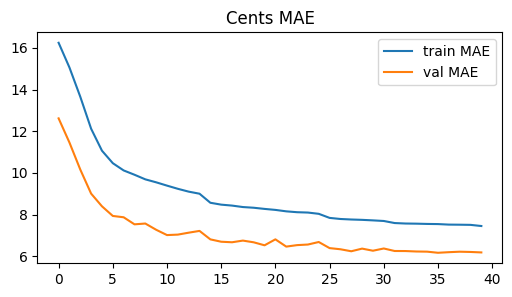

In [ ]:
# 4) Training with curriculum hook (chromatic -> scale-aware)

# packs the labels into a tuple of confidence and target shift
def pack_labels(y):
    conf = tf.ones_like(y, dtype=tf.float32)
    return (y, conf)

# reduces the learning rate on plateau and early stops if the validation loss does not improve
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_shift_cents_mae', mode='min', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_shift_cents_mae', mode='min', patience=7, restore_best_weights=True)
]

history = model.fit(
    train_ds.map(lambda x,y: (x, pack_labels(y))),
    validation_data=(X_val, pack_labels(y_val)),
    epochs=40,
    verbose=1,
    callbacks=callbacks
)

plt.figure(figsize=(6,3))
plt.plot(history.history['shift_cents_mae'], label='train MAE')
plt.plot(history.history['val_shift_cents_mae'], label='val MAE')
plt.legend(); plt.title('Cents MAE'); plt.show()


# Streaming Emulator 

 This section introduces the "Streaming Emulator", which simulates how the trained model would process audio input in a real-time, frame-by-frame (streaming) scenario. The emulator runs the model on one frame (feature vector) at a time, mimicking the constraints of live inference rather than batch processing. This is useful for testing how the model would behave in actual deployment on devices or applications that receive continuous audio input streams.


In [16]:
# 5) Streaming emulator (per-hop inference)

class StreamingEmulator:
    def __init__(self, model, feature_mean, feature_std):
        self.model = model
        self.fm = feature_mean.astype(np.float32)
        self.fs = feature_std.astype(np.float32)

    def step(self, frame):
        # frame: [64]
        x = (frame[None, None, :].astype(np.float32) - self.fm[None,None,:]) / (self.fs[None,None,:] + 1e-8)
        shift, conf = self.model.predict(x, verbose=0)
        return float(shift[0,0,0]), float(conf[0,0,0])

# Example: run over first validation clip frame-by-frame
if len(val_files) > 0:
    arr = np.load(val_files[0])
    frames = arr['logmel']
    sim = StreamingEmulator(model, FEATURE_MEAN, FEATURE_STD)
    out_shift = []
    out_conf = []
    for t in range(frames.shape[0]):
        s,c = sim.step(frames[t])
        out_shift.append(s); out_conf.append(c)
    print('Streaming run frames:', len(out_shift))


Streaming run frames: 501


In [17]:
# 6) Export to SavedModel and TFLite (int8)

export_dir = OUT_DIR / 'saved_model'
export_dir.mkdir(parents=True, exist_ok=True)

sig_inputs = tf.keras.Input(shape=(None, N_MELS), name='features', dtype=tf.float32)
sig_shift, sig_conf = model(sig_inputs)
serve = tf.keras.Model(inputs=sig_inputs, outputs={'shift_cents': sig_shift, 'confidence': sig_conf})

# Keras 3: export SavedModel for TFLite conversion
serve.export(str(export_dir))
print('SavedModel exported to', export_dir)

# Representative dataset windows

def rep_ds():
    for _ in range(256):
        i = np.random.randint(0, len(X_train))
        x = X_train[i:i+1].astype(np.float32)
        yield [x]

converter = tf.lite.TFLiteConverter.from_saved_model(str(export_dir))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_ds
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
(OUT_DIR / 'tflite').mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / 'tflite' / 'full_melody.tflite', 'wb') as f:
    f.write(tflite_model)
print('TFLite model written.')


INFO:tensorflow:Assets written to: /Users/mayagambhir/3600_final/artifacts/full/saved_model/assets


INFO:tensorflow:Assets written to: /Users/mayagambhir/3600_final/artifacts/full/saved_model/assets


Saved artifact at '/Users/mayagambhir/3600_final/artifacts/full/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 64), dtype=tf.float32, name='features')
Output Type:
  Dict[['shift_cents', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)], ['confidence', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)]]
Captures:
  13086018064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086015760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086016336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086017680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086016720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086016528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086015952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086017872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13086016144: TensorSpec(shape=(), dtype=tf.r

W0000 00:00:1765300298.906984 44864409 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765300298.907265 44864409 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-09 12:11:38.909081: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /Users/mayagambhir/3600_final/artifacts/full/saved_model
2025-12-09 12:11:38.909908: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-09 12:11:38.909914: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /Users/mayagambhir/3600_final/artifacts/full/saved_model
2025-12-09 12:11:38.921220: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-09 12:11:38.968405: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /Users/mayagambhir/3600_final/artifacts/full/saved_model
2025-12-09 12:11:38.986295: I tensorflow/cc/saved_model/loader.cc:471] Saved

TFLite model written.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
2025-12-09 12:11:40.882205: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:3705] Skipping runtime version metadata in the model. This will be generated by the exporter.
